In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from typing import Union

from matplotlib import ticker
import numpy as np
import json
import country_converter as coco
from datetime import datetime, timedelta
import requests
import pandas as pd
import geopandas as gpd
import scipy.stats as sps

/Users/khomutovandrey/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/khomutovandrey/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
data = pd.read_csv('../dat/tele_and_gov_data.csv')

data_pol = None
for i in range(16):
    data_part = data.iloc[:,i*9+1:i*9+10]
    reg = data_part.columns[0]
    data_part.columns = list(map(lambda x: x[3:] if '_' in x else 'orders', data_part.columns))
    data_part['year'] = data.iloc[:,0]
    data_part['state'] = reg
    data_pol = pd.concat([data_pol, data_part], axis=0) if data_pol is not None else data_part


Data = pd.read_excel('../dat/surveillance_data.xlsx', sheet_name=None)

data_orders = None
for k in Data.keys():
    data_y = Data[k]
    data_y = data_y.groupby('paragraph').sum().T.reset_index()
    data_y['state'] = data_y['index']
    data_y['year'] = int(k[:4])
    data_orders = pd.concat([data_orders, data_y], axis=0) if data_orders is not None else data_y

data_orders.columns = [x if isinstance(x, str) else 'cases_' + str(x) for x in data_orders.columns]


population = pd.read_csv('../dat/12411-0010-DLAND_population.csv')
population = pd.melt(population, id_vars=['state'], value_vars=population.columns[1:])
population.columns = ['state', 'year', 'population']
population['year'] = population.year.astype('int64')

data = data_pol.merge(data_orders, on=['state', 'year']).merge(population, on=['state', 'year'])

data[['Reg1', 'Reg2', 'Reg3']] = data[['Reg1', 'Reg2', 'Reg3']].replace(['0', 0], '')
data['parties'] = (data.Reg1 
                   + ' ' + data.Reg2
                   + ' ' + data.Reg3).apply(lambda x: tuple(sorted(x.split())))

data['case_4_proba'] = data.cases_4 / data.population

data.head()

,orders,AfD,CDU,Grüne,Linke,Reg1,Reg2,Reg3,SPD,year,state,index,cases_3,cases_4,cases_5,cases_6,population,parties,case_4_proba
0,289,0.0,19.8,5.6,27.2,SPD,Linke,,33.0,2013,BB,BB,104,289,314,289,2449193,"(Linke, SPD)",0.000118
1,301,12.2,23.0,6.2,18.6,SPD,Linke,,31.9,2016,BB,BB,113,288,1580,288,2494648,"(Linke, SPD)",0.000115
2,136,23.5,15.6,10.8,10.7,SPD,Grüne,CDU,26.2,2019,BB,BB,76,136,10,181,2521893,"(CDU, Grüne, SPD)",0.000054
3,267,23.5,15.6,10.8,10.7,SPD,Grüne,CDU,26.2,2020,BB,BB,90,267,0,268,2531071,"(CDU, Grüne, SPD)",0.000105
4,207,23.5,15.6,10.8,10.7,SPD,Grüne,CDU,26.2,2021,BB,BB,81,207,0,207,2537868,"(CDU, Grüne, SPD)",0.000082


In [4]:
from shapely.wkt import loads

geo_df = pd.read_csv('../dat/ne_10m_admin_1_states_provinces/DE_shapes.csv')
geo_df['geometry'] = geo_df.geometry.apply(loads)
geo_df = gpd.GeoDataFrame(geo_df, crs='EPSG:4326')
geo_df['coords'] = geo_df.geometry.apply(lambda x: x.representative_point().coords[:][0])

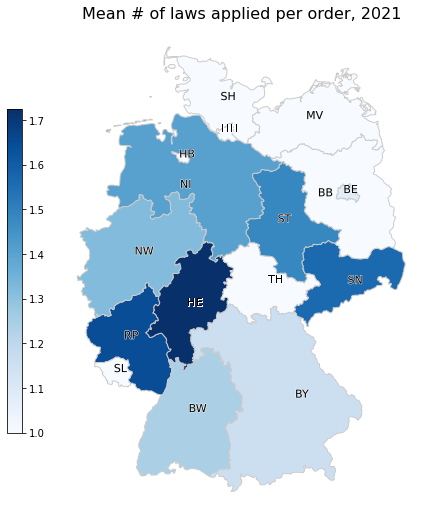

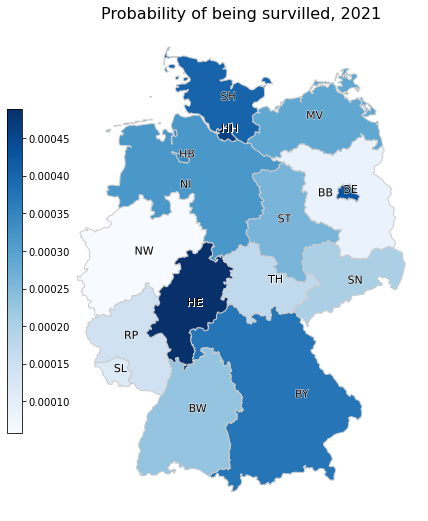

In [5]:
geo_data = geo_df.merge(data, on = 'state')
geo_data['cases_6'] = geo_data.cases_6.apply(lambda x: 1 if x == 0 else x)
geo_data['laws_per_order'] = geo_data.cases_6 / geo_data.cases_4


def plot_map(geo_df: pd.DataFrame, column: str, title: str = None, figname: str = None) -> None:
    """
    Plot german map with colorbar.
    
    arguments:
    geo_df -- data prepared with `data_to_geo`
    column -- value which is used to indicate levels across states, e.g. 'cases_3_per_1k'
    title -- plot titile
    figname -- if provided save figure, e.g. 'map_rel_2021.png'
    """
    cmap = 'Blues' # can use other like 'Reds'
    fig, ax = plt.subplots(1, figsize=(20, 9))

    ax = geo_df.plot(column=column, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
    ax.set_title(title, fontdict={'fontsize': '16', 'fontweight': '3'})

    for idx, row in geo_df.iterrows():
        x = row['coords'][0] - 0.1
        y = row['coords'][1]
        text = plt.annotate(
            text=f"{row['state']}",
            xy=(x,y),
            xytext= (x,y), 
            fontsize=11,
            color='black',
        )
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'),
                           path_effects.Normal()])

    ax.axis('off')
    
    vmin, vmax = geo_df[column].min(), geo_df[column].max()
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
    cbaxes = fig.add_axes([0.35, 0.25, 0.01, 0.5])
    cbar = fig.colorbar(sm, cax=cbaxes)
    if figname:
        plt.savefig(figname, dpi=400)
        
plot_map(geo_data.query('year==2021'), 'laws_per_order', 'Mean # of laws applied per order, 2021')
plot_map(geo_data.query('year==2021'), 'case_4_proba', 'Probability of being survilled, 2021')

In [6]:
data.query('year==2021')[['AfD', 'CDU', 'Grüne', 'Linke', 'case_4_proba']].corr()['case_4_proba']

AfD            -0.328368
CDU            -0.247763
Grüne           0.581077
Linke          -0.158786
case_4_proba    1.000000
Name: case_4_proba, dtype: float64

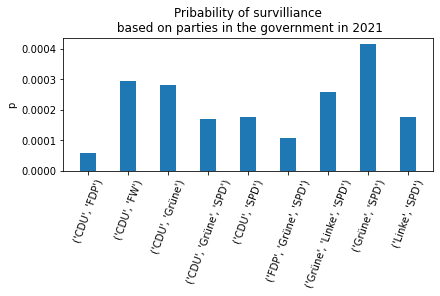

In [7]:
parties_grouped = data.query('year==2021').groupby('parties').sum()[['cases_4', 'population']]
parties_grouped['p'] = parties_grouped.cases_4/parties_grouped.population

fig, ax = plt.subplots(layout='constrained')

width = 0.4
x = np.arange(len(parties_grouped))
offset = 0.01

rect1 = ax.bar(x, parties_grouped.p, width)

# ax.set_xlabel('party')
ax.set_ylabel('p')
ax.set_title('Pribability of survilliance\n based on parties in the government in 2021')
ax.set_xticks(x, parties_grouped.index, rotation=70)
# ax.legend(loc='upper left')

plt.show()

In [8]:
def Wald_test_Bern(n1: int, p1: float, n2: int, p2: float, how: str = 'two-sided'):
    """
    ...
    """
    assert how in ('two-sided', 'greater', 'less'), 'how is not defined'
    if n1 * n2 * (p1 + p2) == 0 :
        return None
    D = p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2 
    W = (p2 - p1) / D**(1/2)
    if how == 'two-sided':
        p = 2 * sps.norm.sf(abs(W))
    elif how == 'greater':
        p = sps.norm.sf(W)
    elif how == 'less':
        p = sps.norm.cdf(W)
    
    return round(W, 2), round(p, 5)
    

def stats_party(data, party):
    party_idx = data.parties.apply(lambda x: party in x)
    h1, n1 = data[~party_idx].sum()[['cases_4', 'population']]
    h2, n2 = data[party_idx].sum()[['cases_4', 'population']]
    p1, p2 = round(h1/n1, 6), round(h2/n2, 6)
    return n1, p1, n2, p2 

parties = ['Linke', 'SPD', 'CDU', 'Grüne', 'FW', 'FDP']

d = {k: [] for k in ('party', 'p_absent', 'n_absent', 'p_present', 'n_present', 'W', 'p_value')}

for party in parties:
    n1, p1, n2, p2 = stats_party(data.query('year==2021'), party)
    W, p = Wald_test_Bern(n1, p1, n2, p2)
    for k, v in zip(d.keys(), (party, p1, n1, p2, n2, W, p)):
        d[k].append(v)

pd.DataFrame(d)

,party,p_absent,n_absent,p_present,n_present,W,p_value
0,Linke,0.000194,75163166,0.000242,8073958,8.41,0.00000
1,SPD,0.000202,48521239,0.000193,34715885,-2.89,0.00389
2,CDU,0.000225,14034378,0.000193,69202746,-7.38,0.00000
3,Grüne,0.000162,41722119,0.000235,41515005,23.63,0.00000
4,FW,0.000181,70060135,0.000294,13176989,22.65,0.00000
5,FDP,0.000246,61206048,0.000067,22031076,-67.37,0.00000


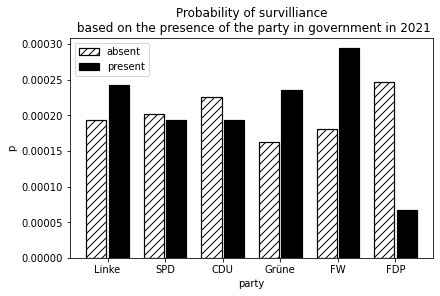

In [9]:
fig, ax = plt.subplots(layout='constrained')

width = 0.35
x = np.arange(len(parties))
offset = 0.02

party_p = pd.DataFrame(d)

# plt.rcParams['hatch.linewidth'] = 0.5

style = {'edgecolor':'black', 'linewidth':1.2}
rect1 = ax.bar(x-width/2-offset, party_p.p_absent, width, label = 'absent', color='white', hatch= '///', **style)
rect3 = ax.bar(x+width/2+offset, party_p.p_present, width, label = 'present', color='black', **style)

ax.set_xlabel('party')
ax.set_ylabel('p')
ax.set_title('Probability of survilliance\n based on the presence of the party in government in 2021')
ax.set_xticks(x, party_p.party)
ax.legend(loc='upper left')

plt.show()

In [10]:
data_2021 = data.query('year==2021')

parties = ['Linke', 'SPD', 'CDU', 'Grüne', 'FW', 'FDP']
dummy_data = pd.DataFrame()

for party in parties:
    dummy_data[party] = data_2021.parties.apply(lambda x: 1 if party in x else 0.)
dummy_data['proba'] = data_2021.case_4_proba

dummy_data.proba =  dummy_data.proba.astype(float)
dummy_data


,Linke,SPD,CDU,Grüne,FW,FDP,proba
4,0.0,1.0,1.0,1.0,0.0,0.0,0.000082
9,1.0,1.0,0.0,1.0,0.0,0.0,0.000353
14,0.0,0.0,1.0,1.0,0.0,0.0,0.000164
19,0.0,0.0,1.0,0.0,1.0,0.0,0.000294
24,1.0,1.0,0.0,1.0,0.0,0.0,0.000191
29,0.0,0.0,1.0,1.0,0.0,0.0,0.000489
34,0.0,1.0,0.0,1.0,0.0,0.0,0.000415
39,1.0,1.0,0.0,0.0,0.0,0.0,0.000176
44,0.0,1.0,1.0,0.0,0.0,0.0,0.000186
49,0.0,0.0,1.0,0.0,0.0,1.0,0.000058


In [11]:
'proba ~ ' + ' + '.join(dummy_data.columns[:-1])

'proba ~ Linke + SPD + CDU + Grüne + FW + FDP'

In [12]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='proba ~ ' + ' + '.join(dummy_data.columns[:-1] + ' -1') , data=dummy_data)

res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  proba   R-squared (uncentered):                   0.750
Model:                            OLS   Adj. R-squared (uncentered):              0.600
Method:                 Least Squares   F-statistic:                              5.008
Date:                Thu, 25 Jan 2024   Prob (F-statistic):                      0.0128
Time:                        12:10:14   Log-Likelihood:                          121.65
No. Observations:                  16   AIC:                                     -231.3
Df Residuals:                      10   BIC:                                     -226.7
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/khomutovandrey/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [119]:
states_low_lpo = geo_data.query('year==2021 and laws_per_order < 1.05')[['state', 'laws_per_order']] 
ok_states = [s for s in states_low_lpo.state]

ok_population = population.merge(states_low_lpo, on='state').query('year==2021')
ok_population['alpha'] = np.power(ok_population.population / ok_population.population.max(), 1/2)

data_2021 = Data['2021_surveillance']
data_2021 = data_2021.query('paragraph==6')[['description_en']+ok_states]
data_2021['overall'] = data_2021[ok_states].T.sum()
data_2021 = data_2021.sort_values('overall')
data_2021['overall_p'] = data_2021.overall / data_2021.overall.sum()
data_2021['crime'] = data_2021.description_en
data_2021.loc[data_2021.overall_p < 0.05, 'crime'] = 'other'
data_2021 = data_2021.groupby('crime').sum()
data_2021

,description_en,BY,SL,SH,NW,BW,BB,MV,HB,HH,TH,BE,overall,overall_p
crime,,,,,,,,,,,,,,
Crimes of robbery and extortion (Section 100a Para. 2 No. 1kStPO),Crimes of robbery and extortion (Section 100a ...,174,3,87,63,110,6,8,3,50,8,62,574,0.053271
"Criminal offenses according to Sections 29a, 30 Paragraph 1 Nos. 1, 2 and 4 as well as Sections 30a and 30b of the Narcotics Act (Section 100a Paragraph 2 No. 7bStPO)","Criminal offenses according to Sections 29a, 3...",1465,22,384,508,876,134,175,92,183,170,437,4446,0.412622
Fraud and computer fraud (Section 100a Paragraph 2 No. 1nStPO),Fraud and computer fraud (Section 100a Paragra...,721,3,117,108,159,18,10,5,66,1,116,1324,0.122877
"Gang theft, residential burglary and serious gang theft (§100a Para. 2 No. 1jStPO)","Gang theft, residential burglary and serious g...",231,17,110,96,178,22,34,0,94,1,135,918,0.085197
Murder and manslaughter (Section 100a Paragraph 2 No. 1hStPO),Murder and manslaughter (Section 100a Paragrap...,160,0,66,50,103,5,13,7,167,32,220,823,0.076381
other,Starting Substances Act (AusgStG) Criminal off...,1154,42,146,261,428,22,43,22,210,30,332,2690,0.249652


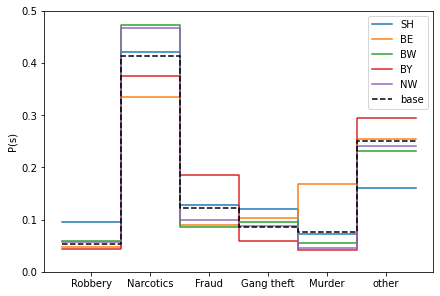

In [145]:
fig, ax = plt.subplots(layout='constrained')

x = np.arange(len(data_2021)+1)
for s in ok_population.sort_values('population').tail(5).state:
    y = list(data_2021[s]/data_2021[s].sum())
    ax.step(x, [y[0]] + y, label=s)
base = list(data_2021.overall_p)
ax.step(x, [base[0]] + base, c='black', ls='--', label='base')
# ax.set_yscale('log')
# ax.set_xlim(20,43)
ax.set_ylim(0.,0.5)
ax.set_ylabel('P(s)')
ax.legend()
ax.set_xticks(x[1:]-.5, ['Robbery', 'Narcotics', 'Fraud', 'Gang theft', 'Murder','other'], rotation=0)
plt.show()

In [162]:
from scipy.stats import chisquare

for s in ok_population.sort_values('population').tail(5).state:
    y = data_2021[s]
    print(s, chisquare(y, data_2021.overall_p * y.sum()))

SH Power_divergenceResult(statistic=73.83268204060597, pvalue=1.6298684305405572e-14)
BE Power_divergenceResult(statistic=183.0849644098325, pvalue=1.1735445584603102e-37)
BW Power_divergenceResult(statistic=53.864780174733966, pvalue=2.234312341189196e-10)
BY Power_divergenceResult(statistic=268.14326051437166, pvalue=7.0088976330569125e-56)
NW Power_divergenceResult(statistic=26.911263307148065, pvalue=5.9357467996051825e-05)
